# 1.Libs and Loading Data

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [178]:
from scipy.stats import binned_statistic_2d

In [179]:
df = pd.read_csv('yellow_tripdata_2016-05.csv')

In [180]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


# 2. Preprocessing

In [181]:
# dt_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
# for col in dt_cols:
#     df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d %H:%M:%S')

In [182]:
#убираем данные с нулевым временем поездки
df = df[df['tpep_dropoff_datetime'] != df['tpep_pickup_datetime']]

In [183]:
# 0 passangers
df = df[df['passenger_count'] != 0] 

In [184]:
# 0 distance
df = df[df['trip_distance'] != 0]

оставляем данные в заданном квадрате Нью-Йорка:

In [185]:
lon1 = -74.25559 
lon2 = -73.70001
lat1 = 40.49612
lat2 = 40.91553

df = df[(df['pickup_longitude']>=lon1) & (df['pickup_longitude']<=lon2) & (df['pickup_latitude']>=lat1) & (df['pickup_latitude']<=lat2)]

# 3. Aggregating

## Making coords

In [186]:
# перегружаем индексы, чтобы в дальнейшем объединить с данными из binned_statistic_2d
df.reset_index(inplace=True)

In [187]:
# читаем данные из файла region.csv
df_reg = pd.read_csv('regions.csv', sep=';')

In [188]:
df_reg.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [189]:
# binlon = np.arange(lon1, lon2, (lon2 - lon1)/50)
# binlat = np.arange(lat1, lat2, (lat2 - lat1)/50)

# создаем список координат по долготе и ширине, для расчета ячеек:
binlon = pd.Series() 
binlon = binlon.append(df_reg['west'])
binlon = binlon.append(df_reg['east'])
binlon = binlon.unique()
binlon.sort()

binlat = pd.Series() 
binlat = binlat.append(df_reg['south'])
binlat = binlat.append(df_reg['north'])
binlat = binlat.unique()
binlat.sort()

In [190]:
# считаем принадлежность исходных данных заданым ячейкам
ret = binned_statistic_2d(df['pickup_longitude'], df['pickup_latitude'], None, 'count', bins=[binlon, binlat],
                          expand_binnumbers=True) 

C:\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [191]:
# конвертируем в DataFrame. данные - номера ячеек по долготе и ширине
df_ret = pd.DataFrame(ret.binnumber.transpose(), columns=['long_bin', 'lat_bin'])

In [192]:
# создаем справочник координат ячеек
df_edges = pd.DataFrame(data={'east': ret.x_edge, 'south': ret.y_edge})

df_edges['west'] = df_edges['east'].shift(1)
df_edges['north'] = df_edges['south'].shift(1)
df_edges.head()

,east,south,west,north
0,-74.255590,40.496120,NaN,NaN
1,-74.244478,40.504508,-74.255590,40.496120
2,-74.233367,40.512896,-74.244478,40.504508
3,-74.222255,40.521285,-74.233367,40.512896
4,-74.211144,40.529673,-74.222255,40.521285


In [193]:
# соединяем два полученнх DataFrame
df_ret = df_ret.merge(df_edges[['west', 'east']], how='left', left_on='long_bin', right_index=True)
df_ret = df_ret.merge(df_edges[['north', 'south']], how='left', left_on='lat_bin', right_index=True)

df_ret = df_ret.merge(df_reg[['region', 'west', 'north']], how='left', on=['west', 'north'])

df_ret.head()

,long_bin,lat_bin,west,east,north,south,region
0,25,33,-73.988912,-73.977800,40.764542,40.772931,1232
1,24,30,-74.000023,-73.988912,40.739378,40.747766,1179
2,24,30,-74.000023,-73.988912,40.739378,40.747766,1179
3,24,23,-74.000023,-73.988912,40.680660,40.689049,1172
4,23,30,-74.011135,-74.000023,40.739378,40.747766,1129


In [194]:
df = df.join(df_ret) #добовляем через index к исходным данным

In [195]:
# df.to_csv('step3_1.csv')

## Hours

In [196]:
# Убираем информацию о минутах и секундах
df['tpep_pickup_dth'] = df['tpep_pickup_datetime'].str.replace(r':\d\d:\d\d', ':00:00')
df['tpep_dropoff_dth'] = df['tpep_dropoff_datetime'].str.replace(r':\d\d:\d\d', ':00:00')

## Grouping

In [197]:
#df = pd.read_csv('step3_1.csv', index_col=0)

In [198]:
# все значения часов и регионов
all_dth = df['tpep_pickup_dth'].unique()
all_reg = df_reg['region'].unique()

In [199]:
# создаем DataFrame со всеми возможными комбинациями часов и ячеек. используем itertools.product
df_final_data = pd.DataFrame(data=list(product(all_reg, all_dth)), columns=['region', 'tpep_pickup_dth']) #data is itertools.product(reg, date_hour)

# объединяем полученный список с исходными данными (аггрегируем через groupby)
df_final_data = df_final_data.merge(df[['region', 'tpep_pickup_dth', 'VendorID']].groupby(by=['region', 'tpep_pickup_dth'], as_index=False).count().rename(columns={'VendorID': 'trips'}),
                                             how='left', on=['region', 'tpep_pickup_dth'])

In [200]:
# убираем пропуски в паре ячейка-час, где не было поездок
df_final_data['trips'].fillna(0, inplace=True)

# 4. Pivot table

In [201]:
# создаем итоговую таблицу (pivot_table)
df_final_pivot = df_final_data.pivot_table(values='trips', index='region', columns='tpep_pickup_dth', fill_value=0)

In [202]:
df_final_pivot.shape

(2500, 744)

In [203]:
df_final_pivot.head()

tpep_pickup_dth,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,2016-05-01 09:00:00,...,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
region,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 5. Visualising taxi's takeoff near Empire-State-Building

Empire-State-Building coordinates: -73.985428, 40.748817

Определяем принадлежность Empire State Building заданным ячейкам:

In [204]:
empire_ret = binned_statistic_2d([-73.985428], [40.748817], None, 'count', bins=[binlon, binlat],
                                 expand_binnumbers=True) 

C:\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [205]:
empire_ret.binnumber

array([[25],
       [31]], dtype=int64)

In [206]:
df_reg[(df_reg['west'] == empire_ret.x_edge[24]) & (df_reg['south'] == empire_ret.y_edge[30])]

,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


нужный нам region - 1231. По данным этого региона строим график

In [207]:
# конвертируем tpep_pickup_dth из string в datetime
df_final_data['tpep_pickup_dth'] = pd.to_datetime(df_final_data['tpep_pickup_dth'], format = '%Y-%m-%d %H:%M:%S')

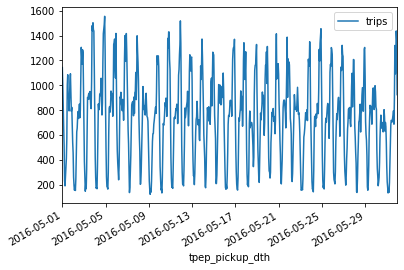

In [208]:
# график
df_final_data[df_final_data['region'] == 1231].plot('tpep_pickup_dth', 'trips')

# 6. Null cell-hour

In [209]:
# кол-во пар ячейка-время, где было ноль поездок:
print('Null cell-hour: %d' %df_final_data['trips'].value_counts()[0])

Null cell-hour: 1718238


In [210]:
df_final_data.to_csv('final_data.csv')